<h1><center>Векторные представления слов</center></h1>



![w2v](https://cdn-images-1.medium.com/max/2600/1*sXNXYfAqfLUeiDXPCo130w.png)

Есть три сценария работы с векторными представлениями:
- Взять предобученную модель
- Обучить свою модель 
- Взять предобученную модель и дообучить ее


## Предобученные модели: RusVectōrēs


На сайте [RusVectōrēs](https://rusvectores.org/ru/) собраны предобученные на различных данных модели для русского языка, а также можно поискать наиболее близкие слова к заданному, посчитать семантическую близость нескольких слов и порешать примеры с помощью «калькулятора семантической близости».


Для других языков также можно найти предобученные модели — например, модели [fastText](https://fasttext.cc/docs/en/english-vectors.html) и [GloVe](https://nlp.stanford.edu/projects/glove/) (о них чуть дальше).

## Gensim

Использовать предобученную модель или обучить свою можно с помощью библиотеки `gensim`. Вот [ее документация](https://radimrehurek.com/gensim/models/word2vec.html).

### Как использовать готовую модель

Модели word2vec бывают разных форматов:

* .vec.gz — обычный текстовый файл 
* .bin.gz — бинарный файл

Загружаются они с помощью одного и того же класса `KeyedVectors`, меняется только параметр `binary` у функции `load_word2vec_format`. 

Если же векторы обучены **не** с помощью word2vec, то для загрузки нужно использовать функцию `load`. Т.е. для загрузки предобученных моделей *glove, fasttext, bpe* и любых других нужна именно она.

Скачаем с RusVectōrēs модель для русского языка, обученную на НКРЯ : https://rusvectores.org/ru/models/

In [1]:
import re
import gensim
import logging
import nltk.data 
import pandas as pd
from nltk.corpus import stopwords
from gensim.models import word2vec
from nltk.tokenize import sent_tokenize, RegexpTokenizer
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/veronika/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
! ls

2_embeddings-Copy1.ipynb
2_embeddings_no_output.ipynb
2_embeddings_with_output.ipynb
IMDB Dataset.csv
alice.txt
cc.en.300.bin
cc.en.300.bin.gz
cc.ru.300.bin
cc.ru.300.bin.gz
clean_text.txt
glove.6B
glove.6B.zip
imdb-dataset-of-50k-movie-reviews.zip
movie_reviews.model
movies_alice.bin
ru_analogy_tagged.txt
ruscorpora_mystem_cbow_300_2_2015.bin.gz


In [3]:
model_path = 'ruscorpora_mystem_cbow_300_2_2015.bin.gz'

model_ru = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=True)

In [4]:
words = ['день_S', 'ночь_S', 'человек_S', 'семантика_S', 'биткоин_S']

Частеречные тэги нужны, поскольку это специфика скачанной модели - она была натренирована на словах, аннотированных их частями речи (и лемматизированных). **Важно!** В названиях моделей на `rusvectores` указано, какой набор тегов они используют (mystem, upos и т.д.)

Попросим у модели 10 ближайших соседей для каждого слова и коэффициент косинусной близости для каждого:

In [5]:
for word in words:
    # есть ли слово в модели? 
    if word in model_ru:
        print(word)
        # выдаем 10 ближайших соседей слова:
        for word, sim in model_ru.most_similar(positive=[word], topn=10):
            # слово + коэффициент косинусной близости
            print(word, ': ', sim)
        print('\n')
    else:
        # Увы!
        print(f'Увы, слова "{word}" нет в модели!')

день_S
неделя_S :  0.7165195941925049
месяц_S :  0.631048858165741
вечер_S :  0.5828739404678345
утро_S :  0.5676207542419434
час_S :  0.5605547428131104
минута_S :  0.5297019481658936
гекатомбеон_S :  0.4897990822792053
денек_S :  0.48224714398384094
полчаса_S :  0.48217129707336426
ночь_S :  0.478074848651886


ночь_S
вечер_S :  0.6946247816085815
утро_S :  0.57301926612854
ноченька_S :  0.5582467317581177
рассвет_S :  0.5553582906723022
ночка_S :  0.5351512432098389
полдень_S :  0.5334426164627075
полночь_S :  0.478694349527359
день_S :  0.4780748784542084
сумерки_S :  0.4390218257904053
фундерфун_S :  0.4340824782848358


человек_S
женщина_S :  0.5979775190353394
парень_S :  0.4991787374019623
мужчина_S :  0.4767409563064575
мужик_S :  0.47384002804756165
россиянин_S :  0.47190436720848083
народ_S :  0.4654741883277893
согражданин_S :  0.45378512144088745
горожанин_S :  0.44368088245391846
девушка_S :  0.44314485788345337
иностранец_S :  0.43849867582321167


семантика_S
семантичес

In [6]:
model_ru['биткоин_S']

KeyError: "word 'биткоин_S' not in vocabulary"

Находим косинусную близость пары слов:

In [7]:
print(model_ru.similarity('человек_S', 'обезьяна_S'))

0.23895611


Построим аналогии: 
* *король: мужчина = королева: женщина* 
 $\Rightarrow$ 
* *король - мужчина + женщина = королева*


Что получится, если вычесть из пиццы Италию и прибавить Сибирь?

* positive — вектора, которые мы складываем
* negative — вектора, которые вычитаем

In [8]:
print(model_ru.most_similar(positive=['пицца_S', 'сибирь_S'], negative=['италия_S'])[0][0])

пельмень_S


In [9]:
model_ru.doesnt_match('пицца_S пельмень_S хот-дог_S ананас_S'.split())

/Library/Python/3.7/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'ананас_S'

## Предобученные модели: GloVe

Скачаем модель с сайта: https://nlp.stanford.edu/projects/glove/

In [10]:
! ls

2_embeddings-Copy1.ipynb
2_embeddings_no_output.ipynb
2_embeddings_with_output.ipynb
IMDB Dataset.csv
alice.txt
cc.en.300.bin
cc.en.300.bin.gz
cc.ru.300.bin
cc.ru.300.bin.gz
clean_text.txt
glove.6B
glove.6B.zip
imdb-dataset-of-50k-movie-reviews.zip
movie_reviews.model
movies_alice.bin
ru_analogy_tagged.txt
ruscorpora_mystem_cbow_300_2_2015.bin.gz


In [11]:
! less ./glove.6B/glove.6B.100d.txt

the -0.038194 -0.24487 0.72812 -0.39961 0.083172 0.043953 -0.39141 0.3344 -0.57545 0.087459 0.28787 -0.06731 0.30906 -0.26384 -0.13231 -0.20757 0.33395 -0.33848 -0.31743 -0.48336 0.1464 -0.37304 0.34577 0.052041 0.44946 -0.46971 0.02628 -0.54155 -0.15518 -0.14107 -0.039722 0.28277 0.14393 0.23464 -0.31021 0.086173 0.20397 0.52624 0.17164 -0.082378 -0.71787 -0.41531 0.20335 -0.12763 0.41367 0.55187 0.57908 -0.33477 -0.36559 -0.54857 -0.062892 0.26584 0.30205 0.99775 -0.80481 -3.0243 0.01254 -0.36942 2.2167 0.72201 -0.24978 0.92136 0.034514 0.46745 1.1079 -0.19358 -0.074575 0.23353 -0.052062 -0.22044 0.057162 -0.15806 -0.30798 -0.41625 0.37972 0.15006 -0.53212 -0.2055 -1.2526 0.071624 0.70565 0.49744 -0.42063 0.26148 -1.538 -0.30223 -0.073438 -0.28312 0.37104 -0.25217 0.016215 -0.017099 -0.38984 0.87424 -0.72569 -0.51058 -0.52028 -0.1459 0.8278 0.27062
, -0.10767 0.11053 0.59812 -0.54361 0.67396 0.10663 0.038867 0.35481 0.06351 -0.094189 0.15786 -0.81665 0.14172 0.21939 0.58505 -0.52158 

In [15]:
import numpy as np

glove = {}
with open('./glove.6B/glove.6B.200d.txt', 'r') as f:
    for line in f:
        word, embedding = line.split(' ',1)
        wordEmbedding = np.array([float(value) for value in embedding[1:].split(' ')])
        glove[word] = wordEmbedding

print(len(glove))

400000


In [16]:
len(glove['hello'])

200

## Предобученные модели: fastText

FastText использует не только векторы слов, но и векторы n-грам. В корпусе каждое слово автоматически представляется в виде набора символьных n-грамм. Скажем, если мы установим n=3, то вектор для слова "where" будет представлен суммой векторов следующих триграм: "<wh", "whe", "her", "ere", "re>" (где "<" и ">" символы, обозначающие начало и конец слова). Благодаря этому мы можем также получать вектора для слов, отсутствуюших в словаре, а также эффективно работать с текстами, содержащими ошибки и опечатки.

* [Статья](https://aclweb.org/anthology/Q17-1010)
* [Сайт](https://fasttext.cc/)
* [Руководство](https://fasttext.cc/docs/en/support.html)
* [Репозиторий](https://github.com/facebookresearch/fasttext)

Есть библиотека `fasttext` для питона (с готовыми моделями можно работать и через `gensim`).

На сайте проекта можно найти предобученные модели для 157 языков (в том числе русского): https://fasttext.cc/docs/en/crawl-vectors.html

In [17]:
import fasttext

#fasttext.util.download_model('ru', if_exists='ignore')
ft = fasttext.load_model('cc.ru.300.bin')

In [ ]:
! ls

In [18]:
ft['модель']

array([ 3.90226841e-02,  2.94893887e-02,  7.75389597e-02,  5.80755584e-02,
       -2.04796474e-02, -2.60778125e-02, -4.31554951e-02, -7.66336499e-03,
        7.35045224e-03,  8.39629862e-03, -3.03267990e-03,  6.59276769e-02,
        2.52222875e-03, -1.30695077e-02,  4.03538942e-02,  1.97116341e-02,
        7.49906823e-02,  3.26768160e-02, -1.30058741e-02,  5.22828884e-02,
        5.06116338e-02, -7.52337575e-02, -3.59434858e-02,  4.87469845e-02,
        1.21515250e-05,  2.44456176e-02, -6.05776981e-02,  3.70115340e-02,
        3.57847698e-02, -1.98335946e-02,  5.92223294e-02, -6.81746677e-02,
       -1.24129206e-02, -3.59787606e-02, -4.27804003e-03,  4.76003997e-02,
       -7.42428824e-02, -1.28765211e-01, -1.36825100e-01,  9.66134109e-03,
       -5.21074906e-02,  1.38343694e-02, -2.73327827e-02,  5.51195256e-02,
        2.06264984e-02,  5.95376752e-02,  2.22954024e-02,  7.45679426e-04,
       -5.00567667e-02,  4.27671038e-02, -2.68213451e-02,  1.15477806e-02,
       -2.37321910e-02,  

У fasttext есть все те же методы, что в gensim, но называются они иначе:

In [19]:
ft.get_nearest_neighbors('чай')

[(0.764227032661438, 'кофе'),
 (0.739784836769104, 'Чай'),
 (0.7071998119354248, 'чая'),
 (0.7018463015556335, 'чаи'),
 (0.6877091526985168, 'свежезаваренный'),
 (0.6864805221557617, 'напиток'),
 (0.6854358911514282, 'каркадэ'),
 (0.6772830486297607, 'чай.'),
 (0.667264461517334, 'чай-'),
 (0.6647352576255798, 'чаёк')]

In [20]:
ft.get_analogies("женщина", "мужчина", "актер")

[(0.8757159113883972, 'актриса'),
 (0.7068515419960022, 'артистка'),
 (0.694389820098877, 'киноактриса'),
 (0.6874823570251465, 'Актриса'),
 (0.6860095262527466, 'кинозвезда'),
 (0.6789741516113281, 'певица'),
 (0.6663230061531067, 'красавица-актриса'),
 (0.6603893637657166, 'актриса.'),
 (0.6569409966468811, 'Киноактриса'),
 (0.6488985419273376, 'актрисса')]

Важная особенность: так как модель обучена на символьных n-граммах, нет проблемы OOV (out of vocabulary) слов:

In [21]:
ft.get_nearest_neighbors('книжонка')

[(0.7441761493682861, 'книженция'),
 (0.7169104218482971, 'книжица'),
 (0.6966618895530701, 'брошюрка'),
 (0.6812918782234192, 'книжонку'),
 (0.6812120079994202, 'книжонок'),
 (0.6565592288970947, 'книжонки'),
 (0.6502901911735535, 'книжонке'),
 (0.6479876637458801, 'книжечка'),
 (0.6242943406105042, 'статейка'),
 (0.6214005351066589, 'книга-то')]

In [22]:
ft.get_nearest_neighbors('компютер')

[(0.7335842251777649, 'компъютер'),
 (0.7109572291374207, 'компютера'),
 (0.7098245024681091, 'компьютер'),
 (0.6971184015274048, 'компютерный'),
 (0.6874867081642151, 'копьютер'),
 (0.674636960029602, 'копм'),
 (0.6739663481712341, 'Компютер'),
 (0.6691707968711853, 'компутер'),
 (0.6670798063278198, 'компютеру'),
 (0.6656312346458435, 'комп')]

## Как обучить свою модель: word2vec

В качестве обучающих данных возьмем англоязычные отзывы о фильмах с сайта IMDB (данные взяты отсюда http://ai.stanford.edu/~amaas/data/sentiment/).

In [23]:
import pandas as pd

pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 800)

In [24]:
data = pd.read_csv("IMDB Dataset.csv")

len(data)

50000

In [25]:
data.head()

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangst...",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on ou...",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've never been impressed with Scarlet Johanson, in this she managed to tone down her ""sexy"" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of h...",positive
3,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them.",negative
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, power and success do to people in the different situations we encounter. <br /><br />This being a variation on the Arthur Schnitzler's play about the same theme, the director transfers the action to the present time New York where all these different characters meet and connect. Each one is connected in one way, or another to the next person, but no one seems to know the previous point of contact. Stylishly, the film has a sophisticated luxurious look. We are taken to see how these people live and the world they live in their own habitat.<br /><br />The only thing on

Убираем из данных ссылки, html-разметку и небуквенные символы, а затем приведем все к нижнему регистру и токенизируем. На выходе получается массив из предложений, каждое из которых представляет собой массив слов. Здесь используется токенизатор из библиотеки `nltk`. 

In [26]:
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
from multiprocessing import Pool
import warnings
warnings.filterwarnings("ignore")

In [27]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [28]:
def review_to_wordlist(review, remove_stopwords=False ):
    # убираем ссылки вне тегов
    review = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", " ", review)
    review_text = BeautifulSoup(review, "lxml").get_text()
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    words = review_text.lower().split()
    if remove_stopwords:
        stops = stopwords.words("english")
        words = [w for w in words if not w in stops]
    return(words)

def review_to_sentences(review, tokenizer=tokenizer, remove_stopwords=False):
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(review_to_wordlist(raw_sentence, remove_stopwords))
    return sentences

In [29]:
with Pool(4) as p:
    sentences = list(tqdm(p.imap(review_to_sentences, data["review"]), total=len(data)))

print(len(sentences))
print(*sentences[:3])


50000
[['one', 'of', 'the', 'other', 'reviewers', 'has', 'mentioned', 'that', 'after', 'watching', 'just', 'oz', 'episode', 'you', 'll', 'be', 'hooked'], ['they', 'are', 'right', 'as', 'this', 'is', 'exactly', 'what', 'happened', 'with', 'me', 'the', 'first', 'thing', 'that', 'struck', 'me', 'about', 'oz', 'was', 'its', 'brutality', 'and', 'unflinching', 'scenes', 'of', 'violence', 'which', 'set', 'in', 'right', 'from', 'the', 'word', 'go'], ['trust', 'me', 'this', 'is', 'not', 'a', 'show', 'for', 'the', 'faint', 'hearted', 'or', 'timid'], ['this', 'show', 'pulls', 'no', 'punches', 'with', 'regards', 'to', 'drugs', 'sex', 'or', 'violence'], ['its', 'is', 'hardcore', 'in', 'the', 'classic', 'use', 'of', 'the', 'word', 'it', 'is', 'called', 'oz', 'as', 'that', 'is', 'the', 'nickname', 'given', 'to', 'the', 'oswald', 'maximum', 'security', 'state', 'penitentary'], ['it', 'focuses', 'mainly', 'on', 'emerald', 'city', 'an', 'experimental', 'section', 'of', 'the', 'prison', 'where', 'all', 

In [30]:
flat_sentences = [item for sublist in sentences for item in sublist]
len(flat_sentences)

536641

In [31]:
# это понадобится нам позже для обучения модели fasttext

with open('clean_text.txt', 'w') as f:
    for s in flat_sentences:
        f.write(' '.join(s))
        f.write('\n')

Обучаем и сохраняем модель. 


Основные параметры:
* данные должны быть итерируемым объектом 
* size — размер вектора, 
* window — размер окна наблюдения,
* min_count — мин. частотность слова в корпусе,
* sg — используемый алгоритм обучения (0 — CBOW, 1 — Skip-gram),
* sample — порог для downsampling'a высокочастотных слов,
* workers — количество потоков,
* alpha — learning rate,
* iter — количество итераций,
* max_vocab_size — позволяет выставить ограничение по памяти при создании словаря (т.е. если ограничение превышается, то низкочастотные слова будут выбрасываться). Для сравнения: 10 млн слов = 1Гб RAM.

**Важно!** Обратите внимание, что тренировка модели не включает предобработку! Это значит, что избавляться от пунктуации, приводить слова к нижнему регистру, лемматизировать их, проставлять частеречные теги придется до тренировки модели (если, конечно, это необходимо для вашей задачи). Т.е. в каком виде слова будут в исходном тексте, в таком они будут и в модели.

In [32]:
print("Training model...")

%time model_en = word2vec.Word2Vec(flat_sentences, workers=4, size=300, min_count=10, window=10, sample=1e-3)

Training model...
CPU times: user 2min 38s, sys: 1.15 s, total: 2min 40s
Wall time: 46.4 s


Смотрим, сколько в модели слов.

In [33]:
print(len(model_en.wv.vocab))

27864


Попробуем оценить модель вручную, аналогично тому, как проверяли предобученные модели.

In [34]:
print(model_en.wv.most_similar(positive=["woman", "actor"], negative=["man"], topn=1))

[('actress', 0.7952963709831238)]


In [35]:
print(model_en.wv.most_similar(positive=["dogs", "man"], negative=["dog"], topn=1))

[('men', 0.5924724340438843)]


In [36]:
print(model_en.wv.most_similar("usa", topn=3))

[('europe', 0.7917618751525879), ('germany', 0.7751280665397644), ('canada', 0.774277925491333)]


In [37]:
print(model_en.wv.doesnt_match("comedy thriller western novel".split()))

novel


### Почему важно, на каких данных обучалась модель?

Посмотрим на ближайшие по смыслу слова к слову "star":
- в модели, обученной на обзорах фильмов
- в модели, обученной на Википедии

In [38]:
print(*model_en.wv.most_similar("star", topn=10), sep='\n')

('stars', 0.6092053651809692)
('hudson', 0.4575274586677551)
('singer', 0.446683406829834)
('stardom', 0.4426514506340027)
('fame', 0.4368395209312439)
('starred', 0.41369011998176575)
('studded', 0.4064015746116638)
('starring', 0.4028608202934265)
('tyrone', 0.4026487469673157)
('icon', 0.3995055556297302)


In [39]:
model_en.similarity('star', 'celebrity')

0.38832128

In [40]:
model_en.similarity('star', 'sky')

0.16640092

In [41]:
model_en.similarity('star', 'shine')

0.20186296

Скачаем предобученную модель fastText для английского:

In [42]:
import fasttext.util
#fasttext.util.download_model('en', if_exists='ignore') 

ft_eng = fasttext.load_model('cc.en.300.bin')

In [43]:
from sklearn.metrics.pairwise import cosine_similarity

In [44]:
cosine_similarity([ft_eng['star']], [ft_eng['celebrity']])

array([[0.44439566]], dtype=float32)

In [45]:
cosine_similarity([ft_eng['star']], [ft_eng['sky']])

array([[0.29363436]], dtype=float32)

In [46]:
cosine_similarity([ft_eng['star']], [ft_eng['shine']])

array([[0.26306346]], dtype=float32)

### Как дообучить существующую модель

При тренировке модели "с нуля" веса инициализируются случайно, однако можно использовать для инициализации векторов веса из предобученной модели, таким образом как бы дообучая ее.

Сначала посмотрим близость какой-нибудь пары слов в имеющейся модели, чтобы потом сравнить результат с дообученной.

In [47]:
model_en.wv.similarity('white', 'rabbit')

0.3138753

В качестве дополнительных данных для обучения возьмем английский текст «Алисы в Зазеркалье».

In [48]:
with open("alice.txt", 'r', encoding='utf-8') as f:
    text = f.read()

text = re.sub('\n', ' ', text)
sents = sent_tokenize(text)

punct = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~„“«»†*—/\-‘’'
clean_sents = []

for sent in sents:
    s = [w.lower().strip(punct) for w in sent.split()]
    clean_sents.append(s)
    
print(clean_sents[:2])

[['through', 'the', 'looking-glass', 'by', 'lewis', 'carroll', 'chapter', 'i', 'looking-glass', 'house', 'one', 'thing', 'was', 'certain', 'that', 'the', 'white', 'kitten', 'had', 'had', 'nothing', 'to', 'do', 'with', 'it', '', 'it', 'was', 'the', 'black', 'kitten’s', 'fault', 'entirely'], ['for', 'the', 'white', 'kitten', 'had', 'been', 'having', 'its', 'face', 'washed', 'by', 'the', 'old', 'cat', 'for', 'the', 'last', 'quarter', 'of', 'an', 'hour', 'and', 'bearing', 'it', 'pretty', 'well', 'considering', 'so', 'you', 'see', 'that', 'it', 'couldn’t', 'have', 'had', 'any', 'hand', 'in', 'the', 'mischief']]


Чтобы дообучить модель, надо сначала ее сохранить, а потом загрузить. Все параметры тренировки (размер вектора, мин. частота слова и т.п.) будут взяты из загруженной модели, т.е. задать их заново нельзя.

**NB!** Дообучить можно только полную модель, а `KeyedVectors` — нельзя. Поэтому сохранять модель нужно в соотвествующем формате. Подробнее о разнице [вот тут](https://radimrehurek.com/gensim/models/keyedvectors.html).

In [49]:
model_path = "movie_reviews.model"

print("Saving model...")
model_en.save(model_path)

Saving model...


In [50]:
model = word2vec.Word2Vec.load(model_path)

model.build_vocab(clean_sents, update=True)
model.train(clean_sents, total_examples=model.corpus_count, epochs=5)

(97278, 150225)

"Белый" и "кролик" стали ближе друг к другу!

In [51]:
model.wv.similarity('white', 'rabbit')

0.33047336

<h1><center>Классификация текстов</center></h1>

Сегодня мы подробнее познакомимся с задачей классификации текстов на два или более классов.

У нас есть [набор данных отзывов на фильмы IMDB](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews), который часто используют при разработке и оценке моделей классификации текстов. Каждый из отзывов в наборе данных имеет свою оценку: является ли он позитивным или негативным.

**Цель:** Используя данные отзывов IMDB, построить модель, которая на основе текста отзыва сможет определять, относится ли он к позитивнму или к негативному классу.

## План работы
* Подготовка данных
* Классификация с помощью Word2Vec:
    * Обучение модели Word2Vec
    * Построение векторов для текстов через среднее векторов слов
    * Построение векторов для текстов через средневзвешенное векторов слов

## Подготовка данных



Для обучения нейросетевых моделей (далее) мы будем использовать популярный фреймворк [PyTorch](https://pytorch.org/).

В предположении, что PyTorch уже установлен, поставим дополнительные модули (torchvision и torchtext) и загрузим модель для токенизации:

In [1]:
!pip install torchvision

In [2]:
!pip install torchtext

Загрузим датасет IMDB из torchtext, это будет удобно для дальнейшего использования этих данных при обучении нейронной сети.

In [3]:
import numpy as np
import torch
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score,classification_report,confusion_matrix
from torchtext import data
from torchtext import datasets
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter,defaultdict
%matplotlib inline
import seaborn as sns

print(torch.__version__)

SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

TEXT = data.Field(tokenize='spacy')
LABEL = data.LabelField()

train_src, test = datasets.IMDB.splits(TEXT, LABEL)

1.6.0
downloading aclImdb_v1.tar.gz


Разделим данные на обучаующую и тестовую выборку и преобразуем их в формат, удобный для построения классических моделей машинного обучения.

In [5]:
X_train = [example.text for example in train_src]
y_train = [example.label for example in train_src]

X_test = [example.text for example in test]
y_test = [example.label for example in test]


In [8]:
from collections import Counter

print ("total train examples %s" % len(y_train))
print ("total test examples %s" % len(y_test))

train_counter = Counter(y_train)
test_counter = Counter(y_test)

print ("{0} positive and {1} negative examples in test".format(test_counter['pos'],test_counter['neg']))
print ("{0} positive and {1} negative examples in test".format(test_counter['pos'],test_counter['neg']))

total train examples 25000
total test examples 25000
12500 positive and 12500 negative examples in test
12500 positive and 12500 negative examples in test


Можно видеть, что классы сбалансированы: количество позитивных и негативных отзывов совпадают.

Посмотрим на примеры позитивного и негативного отзыва.

In [10]:
print("Negative example:\n{0}\n\n".format(' '.join(X_train[0])))
print("Positive example:\n{0}\n\n".format(' '.join(X_train[-1])))

Negative example:
For a movie that gets no respect there sure are a lot of memorable quotes listed for this gem . Imagine a movie where Joe Piscopo is actually funny ! Maureen Stapleton is a scene stealer . The Moroni character is an absolute scream . Watch for Alan " The Skipper " Hale jr . as a police Sgt .


Positive example:
Not that I dislike childrens movies , but this was a tearjerker with few redeeming qualities . M.J. Fox was the perfect voice for Stuart and the rest of the talent was wasted . Hugh Laurie can be amazingly funny , but is not given the chance in this movie . It´s sugar - coated sugar and would hardly appeal to anyone over 7 years of age . See Toy Story , Monsters Inc. or Shrek instead . 3/10




## Классификация с помощью Word2Vec

Подробно языковая модель *Word2Vec* была рассмотрена на предыдущей неделе курса.

Здесь мы будем использовать эту модель для получения векторных представлений слов.

In [8]:
from gensim.models import Word2Vec
# # model = Word2Vec(X_train, size=100, window=5, min_count=5, workers=4)
# # model.save("word2vec.model")

In [9]:
w2v_model = Word2Vec.load("word2vec.model")

Чтобы решить задачу классификации текстов, нам нужно каждому тексту поставить в соответствие вектор.

Реализуем класс *MeanEmbeddingVectorizer*, с помощью которого будем получать вектора для текстов отзывов на основе векторов слов.
Вектор каждого текста будет равен среднему векторов входящих в него слов.

In [10]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(list(word2vec.values())[0])

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

Попробуем также немного другой подход $-$ будем получать вектор для текста как средневзвешенное векторов входящих в него слов с весами *tf-idf*.

Для этого реализуем класс *TfidfEmbeddingVectorizer*.

In [11]:
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(list(word2vec.values())[0])

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

Преобразуем модель Word2Vec в словарь для дальнейшего использования для векторизации текстов.

In [26]:
w2v = dict(zip(w2v_model.wv.index2word, w2v_model.wv.syn0))

Для классификации будем использовать модель [случайного леса](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) из scikit-learn.

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

rfc_w2v = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)),
    ("extra trees", RandomForestClassifier(n_estimators=20))])
rfc_w2v_tfidf = Pipeline([
    ("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)),
    ("extra trees", RandomForestClassifier(n_estimators=20))])

In [17]:
%time rfc_w2v.fit(X_train,y_train)
pred = rfc_w2v.predict(X_test)

CPU times: user 8.03 s, sys: 56.2 ms, total: 8.09 s
Wall time: 8.12 s


Построим отчет по предсказаниям модели (с помощью MeanEmbeddingVectorizer) на тестовой выборке. Выведем точность (precision), полноту (recall) и f1-меру для позитивного и негативного классов, а также количество объектов каждого класса (support) в тестовой выборке.

Precision:   0.60
Recall:   0.60
F1-measure:   0.60
Accuracy:   0.60
              precision    recall  f1-score   support

         neg       0.59      0.67      0.63     12500
         pos       0.62      0.53      0.57     12500

    accuracy                           0.60     25000
   macro avg       0.60      0.60      0.60     25000
weighted avg       0.60      0.60      0.60     25000



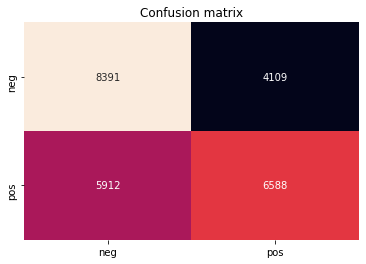

In [19]:
print("Precision: {0:6.2f}".format(precision_score(y_test, pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, pred)))
print(classification_report(y_test, pred))
labels = rfc_w2v.classes_


sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

В данном случае классы сбалансированы (количество объектов позитивного и негативного классов совпадают), поэтому в качестве метрики качества можно использовать *accuracy*.

In [20]:
%time rfc_w2v_tfidf.fit(X_train,y_train)
pred = rfc_w2v_tfidf.predict(X_test)

CPU times: user 1min 44s, sys: 1.19 s, total: 1min 45s
Wall time: 1min 45s


Теперь выведем результаты работы классификатора на признаках из *TfidfEmbeddingVectorizer*.

Precision:   0.62
Recall:   0.62
F1-measure:   0.62
Accuracy:   0.62
              precision    recall  f1-score   support

         neg       0.61      0.68      0.64     12500
         pos       0.64      0.56      0.60     12500

    accuracy                           0.62     25000
   macro avg       0.62      0.62      0.62     25000
weighted avg       0.62      0.62      0.62     25000



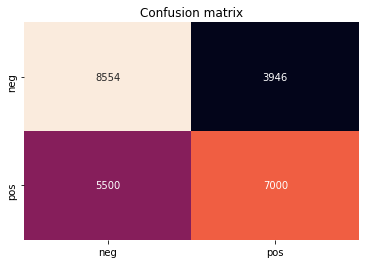

In [21]:
print("Precision: {0:6.2f}".format(precision_score(y_test, pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, pred)))
print(classification_report(y_test, pred))
labels = rfc_w2v.classes_


sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

Можно видеть, что при использовании *TfidfEmbeddingVectorizer* метрика Accuracy немного увеличилась по сравнению c *MeanEmbeddingVectorizer* $-$ с 0.60 до 0.62.